# Calculate Metrics

**Description:** This notebook compares different groups of experiments, using the metrics described in each cell.

**Real Time**
* Burst duration
* Rise duration
* Decay duration
* Interval duration
* SNA duration

**Developmental Time**
* At Onset
* At Hatching
* Per Burst
* CDF

**Other Features**
* Amplitude
* AUC Bins
* Local Peaks

## Import Libraries

In [282]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind 
from scipy import signal as spsig
import seaborn as sns

from pasna_analysis import Experiment, ExperimentConfig, Group, utils
from alanafunctions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [ ]:
%load_ext autoreload
%autoreload 2
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind 
from scipy import signal as spsig
import seaborn as sns

from pasna_analysis import Experiment, ExperimentConfig, Group, utils

wt_config  = {
    '20240611_25C': ExperimentConfig(first_peak_threshold=30, to_exclude=[4,9,12,13,15,17,18,19,21,23]), 
    '20240919_25C': ExperimentConfig(first_peak_threshold=30, to_exclude=[2,5,6,7,11,14,16,18])
}

vglut_config = {
    '20240828-vglutdf': ExperimentConfig(first_peak_threshold=30, to_exclude=[3,6,9]), # EMB 3,6,9
    '20240829-vglutdf': ExperimentConfig(first_peak_threshold=30, to_exclude=[6,8]), # EMB 6,8
    '20240830-vglutdf': ExperimentConfig(first_peak_threshold=30, to_exclude=[6]) # EMB 6
}

vgat_config = {
    '20241008_vgatdf': ExperimentConfig(first_peak_threshold=30, to_exclude=[2,4]),
    '20241009_vgatdf': ExperimentConfig(first_peak_threshold=30, to_exclude=[7,18,19]),
    '20241010_vgatdf': ExperimentConfig(first_peak_threshold=30, to_exclude=[8]),
    '20241011_vgatdf': ExperimentConfig(first_peak_threshold=30, to_exclude=[2,4,11,5]),
}

rdl_folder = 'rdl'
rdl_config = {
    '20250211_rdl': ExperimentConfig(first_peak_threshold=30, to_exclude=[7]),
    '20250212_rdl': ExperimentConfig(first_peak_threshold=30, to_exclude=[12]),
    '20250213_rdl': ExperimentConfig(first_peak_threshold=30, to_exclude=[7, 10]),
    '20250518_RdlMutant_R': ExperimentConfig(first_peak_threshold=30, to_exclude=[1,2,5,8,13,15]),
}

ptx_folder = 'ptx'
ptx_config = {
    '20240723_PTXEXP': ExperimentConfig(first_peak_threshold=0, to_exclude=[5,7,10,12,15,22,27]),
    '20240725_PTXEXP': ExperimentConfig(first_peak_threshold=0, to_exclude=[5,6,7,11,17,19,23,28,30]),
}

vgatvglut_folder = 'vgatvglut'
vgatvglut_config = {
    '20250507_R_VgatVglutMutant': ExperimentConfig(first_peak_threshold=0, to_exclude=[]),
}

vchat_folder = 'vchatdf'
vchat_config = {
    '20250501vacht1-df': ExperimentConfig(first_peak_threshold=0, to_exclude=[]),
}

wt_experiments = {}
for exp, config in wt_config.items():
    exp_path = Path.cwd().parent.joinpath('data', '25C', exp)
    wt_experiments[exp] = Experiment(exp_path, first_peak_threshold=config.first_peak_threshold, to_exclude=config.to_exclude, dff_strategy='local_minima')

vglut_experiments = {}
for exp, config in vglut_config.items():
    exp_path = Path.cwd().parent.joinpath('data', 'vglut', exp)
    vglut_experiments[exp] = Experiment(exp_path, first_peak_threshold=config.first_peak_threshold, to_exclude=config.to_exclude, dff_strategy='local_minima')

vgat_experiments = {}
for exp, config in vgat_config.items():
    exp_path = Path.cwd().parent.joinpath('data', 'vgat', exp)
    vgat_experiments[exp] = Experiment(exp_path, first_peak_threshold=config.first_peak_threshold, to_exclude=config.to_exclude, dff_strategy='local_minima')

rdl_experiments = {}
for exp, config in rdl_config.items():
    exp_path = Path.cwd().parent.joinpath('data', rdl_folder, exp)
    rdl_experiments[exp] = Experiment(exp_path, config.first_peak_threshold, config.to_exclude, dff_strategy='local_minima', hatches=True)

ptx_experiments = {}
for exp, config in ptx_config.items():
    exp_path = Path.cwd().parent.joinpath('data', ptx_folder, exp)
    ptx_experiments[exp] = Experiment(exp_path, config.first_peak_threshold, config.to_exclude, dff_strategy='local_minima', hatches=True)

vgatvglut_experiments = {}
for exp, config in vgatvglut_config.items():
    exp_path = Path.cwd().parent.joinpath('data', vgatvglut_folder, exp)
    vgatvglut_experiments[exp] = Experiment(exp_path, config.first_peak_threshold, config.to_exclude, dff_strategy='local_minima')

vchat_experiments = {}
for exp, config in vchat_config.items():
    exp_path = Path.cwd().parent.joinpath('data', vchat_folder, exp)
    vchat_experiments[exp] = Experiment(exp_path, config.first_peak_threshold, config.to_exclude, dff_strategy='local_minima')

wt = Group('WT', wt_experiments)
vglut = Group('VGluT-', vglut_experiments)
vgat = Group('VGAT-', vgat_experiments)
rdl = Group('Rdl-', rdl_experiments)
ptx = Group('PTX', ptx_experiments)
vgatvglut = Group('VGAT-,\nVGluT-', vgatvglut_experiments)
vchat = Group('VChAT-', vchat_experiments)

groups = [wt, vglut, vgat, rdl, ptx, vgatvglut, vchat]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
First peak detected before 30 mins. Skipping emb3..


## Configure Plot Style

Customize the Matplotlib plots with rcParams. For a full list of parameters see [matplotlib.rcParams](https://matplotlib.org/stable/api/matplotlib_configuration_api.html#default-values-and-styling)

In [284]:
num_episodes = 15

episode_metrics_rc = {
    'figure.figsize': (num_episodes/2, num_episodes/4),
    'figure.frameon': False,

    'lines.linewidth': 1,

    'font.family': 'Arial',
    'font.size': 20,

    'xtick.major.size': 10, # length
    'xtick.major.width': 2,
    'ytick.major.size': 10, # length
    'ytick.major.width': 2,

    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.labelpad': 10,
    'axes.linewidth': 2.5
}

num_groups = len(groups)
group_metrics_rc = {
    'figure.figsize': (num_groups*1, num_groups/2),
    'figure.frameon': False,

    'lines.linewidth': 2.25,

    'font.family': 'Arial',
    'font.size': 20,

    'xtick.major.size': 10, # length
    'xtick.major.width': 2,
    'ytick.major.size': 10, # length
    'ytick.major.width': 2,

    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.labelpad': 10,
    'axes.linewidth': 2.5
}


# Overview

## Sample Size

Prints a table displaying the total sample size for each group, plus the sample size for each experiment in a group. 

In [285]:
data = {"Group":[], "Exp":[], "Emb":[]}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos:
            data["Group"].append(group.name)
            data["Exp"].append(exp.name)
            data["Emb"].append(emb)

data = pd.DataFrame(data)

num_per_exp = data.groupby(["Group", "Exp"]).size().reset_index(name="N")
num_per_group = data.groupby("Group").size().reset_index(name="N")
num_per_group["Exp"] = "Total"
num_per_group = num_per_group[["Group", "Exp", "N"]]

combined = pd.concat([num_per_exp, num_per_group], ignore_index=True)

flipped = combined[::-1]
print(flipped.to_string(index=False))

         Group                        Exp  N
            WT                      Total 23
        VGluT-                      Total 21
VGAT-,\nVGluT-                      Total 13
         VGAT-                      Total 16
        VChAT-                      Total  3
          Rdl-                      Total 14
           PTX                      Total 38
            WT               20240919_25C 15
            WT               20240611_25C  8
        VGluT-           20240830-vglutdf  7
        VGluT-           20240829-vglutdf  7
        VGluT-           20240828-vglutdf  7
VGAT-,\nVGluT- 20250507_R_VgatVglutMutant 13
         VGAT-            20241011_vgatdf  7
         VGAT-            20241010_vgatdf  3
         VGAT-            20241009_vgatdf  3
         VGAT-            20241008_vgatdf  3
        VChAT-          20250501vacht1-df  3
          Rdl-               20250213_rdl  5
          Rdl-               20250212_rdl  5
          Rdl-               20250211_rdl  4
          

# Real Time

## Burst Duration

/Users/alanaevora/Documents/Duke/code/pasna_analysis/pasna_analysis/trace.py:299: PeakPropertyWarning: some peaks have a prominence of 0
  _, _, start_idxs, end_idxs = spsig.peak_widths(
/Users/alanaevora/Documents/Duke/code/pasna_analysis/pasna_analysis/trace.py:299: PeakPropertyWarning: some peaks have a width of 0
  _, _, start_idxs, end_idxs = spsig.peak_widths(
/Users/alanaevora/Documents/Duke/code/pasna_analysis/notebooks/alanafunctions.py:402: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=dataframe, x=x, y=y, hue=category, linestyle=linestyle, ax=ax)


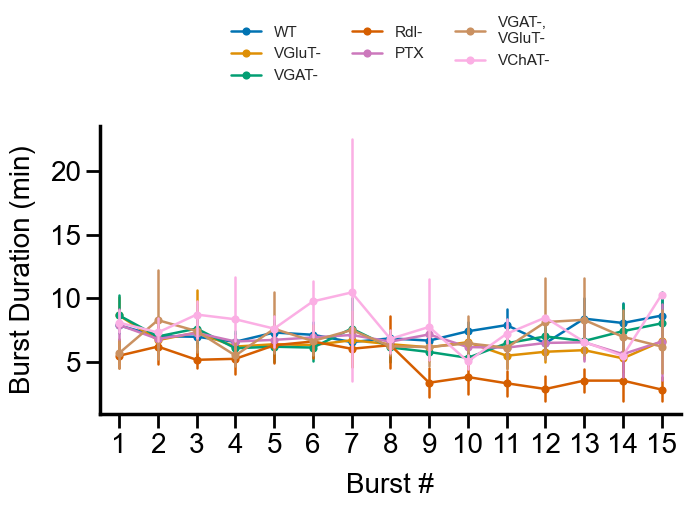

In [286]:
data = {"Group": [], "Burst Duration (min)": [], "Burst #": []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos.values():
            trace = emb.trace
            for i, duration in zip(range(num_episodes), trace.peak_durations):
                data["Group"].append(group.name)
                data["Burst Duration (min)"].append(duration / 60)
                data["Burst #"].append(i+1)

data = pd.DataFrame(data)

plot_pointplot(data, x="Burst #", y="Burst Duration (min)", category="Group", rc=episode_metrics_rc)

## Rise Duration

/Users/alanaevora/Documents/Duke/code/pasna_analysis/notebooks/alanafunctions.py:402: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=dataframe, x=x, y=y, hue=category, linestyle=linestyle, ax=ax)


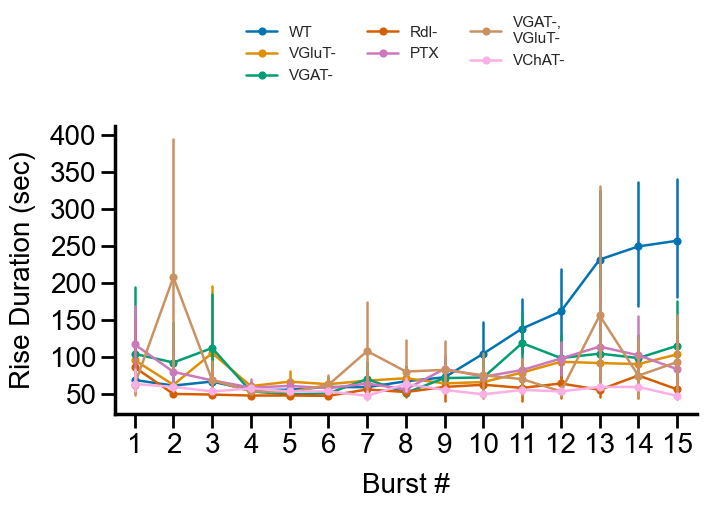

In [287]:
data = {"Group": [], "Rise Duration (sec)": [], "Burst #": []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos.values():
            trace = emb.trace
            for i, rise in zip(range(num_episodes), trace.peak_rise_times):
                data["Group"].append(group.name)
                data["Rise Duration (sec)"].append(rise)
                data["Burst #"].append(i+1)

data = pd.DataFrame(data)

plot_pointplot(data, x="Burst #", y="Rise Duration (sec)", category="Group", rc=episode_metrics_rc)

## Decay Duration

/Users/alanaevora/Documents/Duke/code/pasna_analysis/notebooks/alanafunctions.py:402: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=dataframe, x=x, y=y, hue=category, linestyle=linestyle, ax=ax)


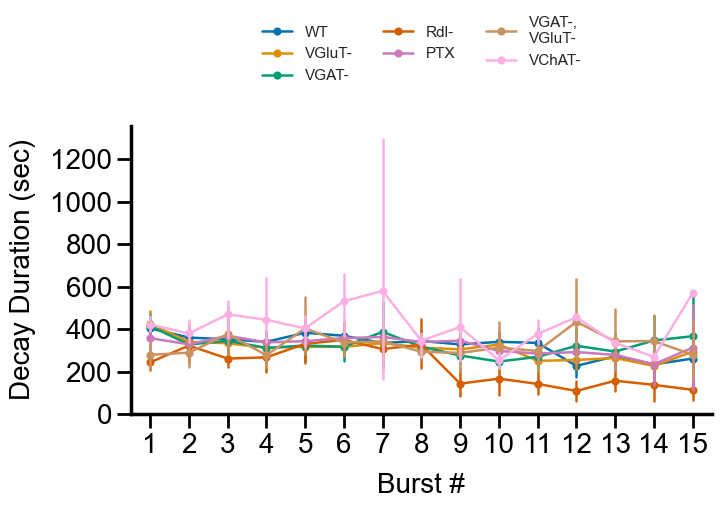

In [288]:
data = {"Group": [], "Decay Duration (sec)": [], "Burst #": []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos.values():
            trace = emb.trace
            for i, decay in zip(range(num_episodes), trace.peak_decay_times):
                data["Group"].append(group.name)
                data["Decay Duration (sec)"].append(decay)
                data["Burst #"].append(i+1)

data = pd.DataFrame(data)

plot_pointplot(data, x="Burst #", y="Decay Duration (sec)", category="Group", rc=episode_metrics_rc)

## Interval Duration

/Users/alanaevora/Documents/Duke/code/pasna_analysis/notebooks/alanafunctions.py:402: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=dataframe, x=x, y=y, hue=category, linestyle=linestyle, ax=ax)


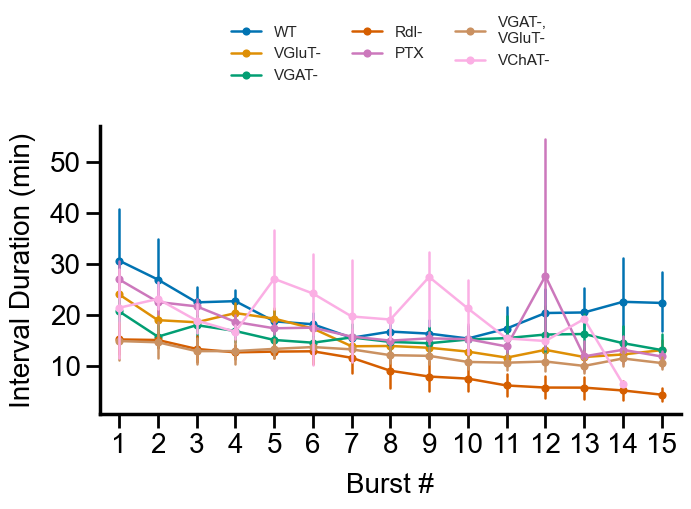

In [289]:
data = {"Group": [], "Interval Duration (min)": [], "Burst #": []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos.values():
            trace = emb.trace
            for i, interval in zip(range(num_episodes), trace.peak_intervals):
                data["Group"].append(group.name)
                data["Interval Duration (min)"].append(interval / 60)
                data["Burst #"].append(i+1)

data = pd.DataFrame(data)

plot_pointplot(data, x="Burst #", y="Interval Duration (min)", category="Group", rc=episode_metrics_rc)

## SNA Duration

/Users/alanaevora/Documents/Duke/code/pasna_analysis/notebooks/alanafunctions.py:402: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=dataframe, x=x, y=y, hue=category, linestyle=linestyle, ax=ax)


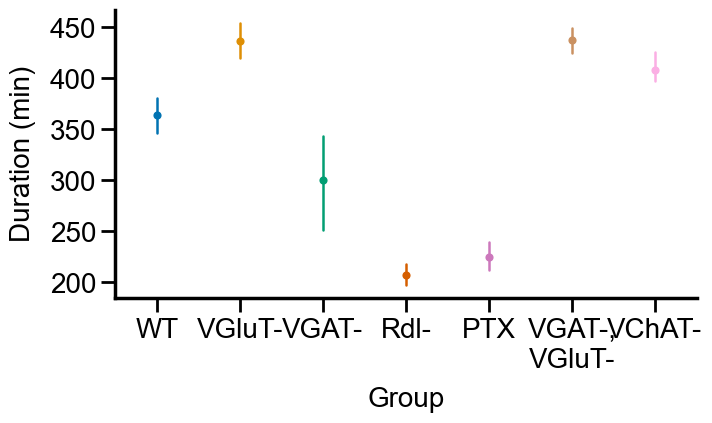

In [290]:
data = {"Group": [], "Duration (min)": []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos.values():
            trace = emb.trace
            data["Group"].append(group.name)
            duration = (trace.time[trace.trim_idx] - trace.peak_times[0]) / 60
            data["Duration (min)"].append(duration)

data = pd.DataFrame(data)

plot_pointplot(data, x="Group", y="Duration (min)", category="Group", rc=episode_metrics_rc, xmax=len(groups)-1)

# Developmental Time

## Dev Time at Onset

/Users/alanaevora/Documents/Duke/code/pasna_analysis/notebooks/alanafunctions.py:402: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=dataframe, x=x, y=y, hue=category, linestyle=linestyle, ax=ax)


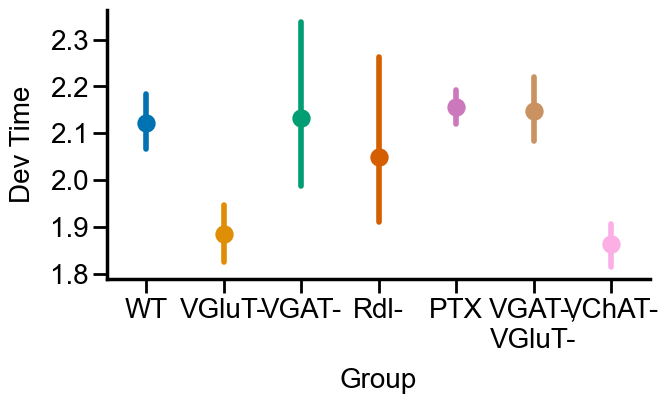

In [291]:
data = {"Group": [], "Dev Time": []}

for group in groups:
    for exp in group.experiments.values():
        num = 0
        for emb in exp.embryos.values():
            num = num + 1
            trace = emb.trace
            time_first_peak = trace.peak_times[0]
            dev_time_first_peak = emb.get_DT_from_time(time_first_peak)
            data["Dev Time"].append(dev_time_first_peak)
            data["Group"].append(group.name)

data = pd.DataFrame(data)

plot_pointplot(data, x="Group", y="Dev Time", category="Group", rc=group_metrics_rc, xmax=len(groups)-1)

## Dev Time at Hatching

/Users/alanaevora/Documents/Duke/code/pasna_analysis/notebooks/alanafunctions.py:402: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=dataframe, x=x, y=y, hue=category, linestyle=linestyle, ax=ax)


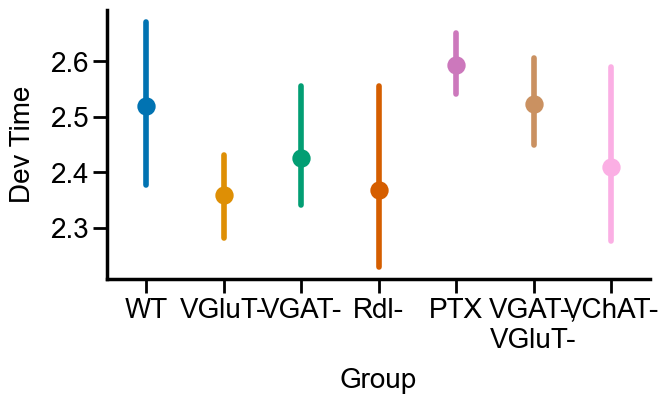

In [292]:
data = {"Group": [], "Dev Time": []}

for group in groups:
    for exp in group.experiments.values():
        num = 0
        for emb in exp.embryos.values():
            num = num + 1
            trace = emb.trace
            time_hatching = trace.time[trace.trim_idx]
            dev_time_first_peak = emb.get_DT_from_time(time_hatching)

            data["Dev Time"].append(dev_time_first_peak)
            data["Group"].append(group.name)

data = pd.DataFrame(data)

plot_pointplot(data, x="Group", y="Dev Time", category="Group", rc=group_metrics_rc, xmax=len(groups)-1)

## Dev Time Per Burst

/Users/alanaevora/Documents/Duke/code/pasna_analysis/notebooks/alanafunctions.py:402: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=dataframe, x=x, y=y, hue=category, linestyle=linestyle, ax=ax)


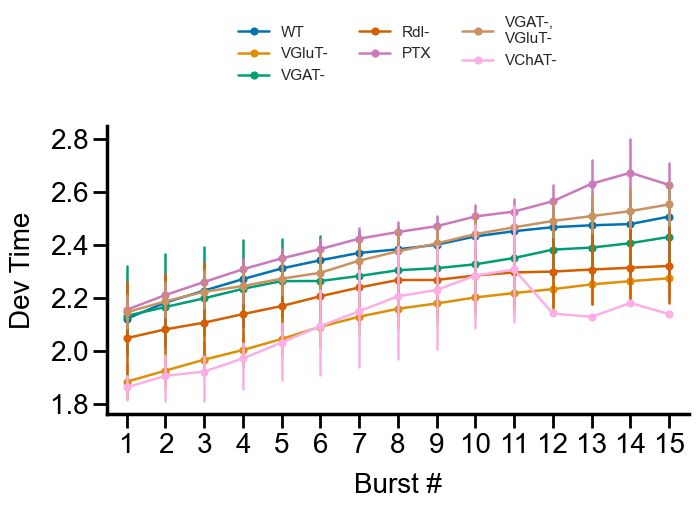

In [293]:
data = {"Group": [], "Dev Time": [], "Burst #": []}

for group in groups:
    for exp in group.experiments.values():
        for emb_n, emb in enumerate(exp.embryos.values()):
            trace = emb.trace
            for i, t in zip(range(num_episodes), trace.peak_times):
                data["Group"].append(group.name)
                data["Dev Time"].append(emb.get_DT_from_time(t))
                data["Burst #"].append(i+1)

data = pd.DataFrame(data)

plot_pointplot(data, x="Burst #", y="Dev Time", category="Group", rc=episode_metrics_rc)

## CDF Dev Time Per Burst

In [294]:
data = {"Group": [], "Dev Time": []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos.values():
            trace = emb.trace
            dev_times = [emb.get_DT_from_time(t) for t in trace.peak_times]
            data["Dev Time"].extend(dev_times)
            data["Group"].extend([group.name] * len(dev_times))

data = pd.DataFrame(data)

plot_cdf(data, x="Group", category=)

SyntaxError: invalid syntax (1495993638.py, line 13)

# Other Features

## Burst Amplitude

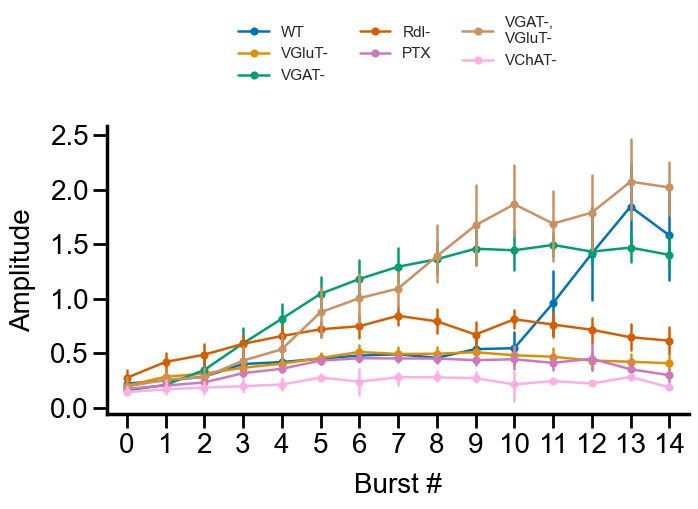

In [ ]:
data = {"Group": [], "Amplitude": [], "Burst #": []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos.values():
            t = emb.trace
            for i, amp in zip(range(num_episodes), t.peak_amplitudes):
                data["Amplitude"].append(amp)
                data["Group"].append(group.name)
                data["Burst #"].append(i)

data = pd.DataFrame(data)

plot_pointplot(data, x="Burst #", y="Amplitude", category="Group", rc=episode_metrics_rc)

## AUC Bins

<class 'list'>


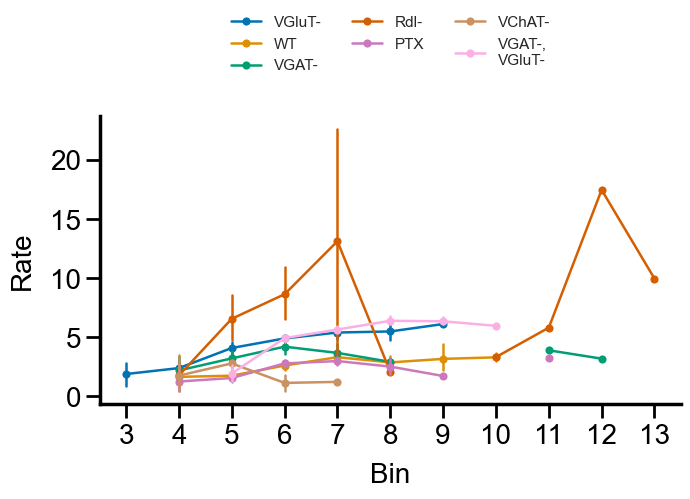

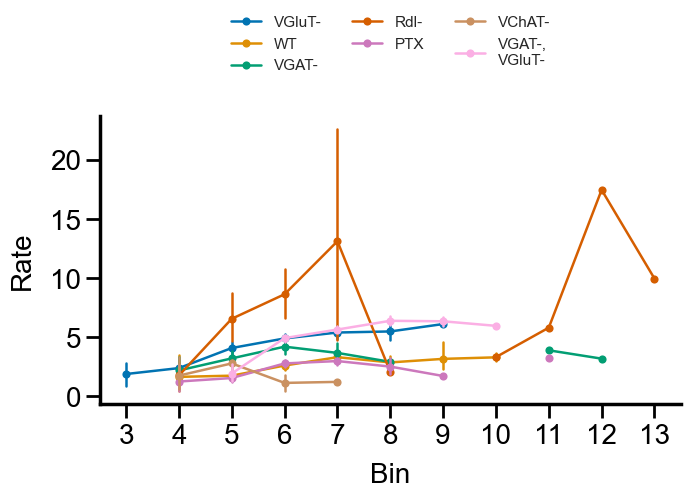

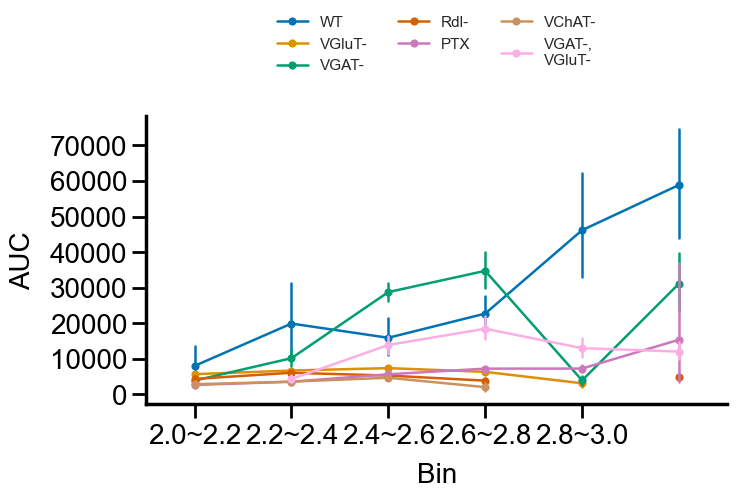

In [ ]:
data = {"Group": [], "AUC": [], "Bin": []}

n_bins = 5
first_bin = 2
bin_width = 0.2

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos.values():
            trace = emb.trace
            dev_time_at_peaks = emb.get_DT_from_time(trace.peak_times)
            bins = [first_bin + j * bin_width for j in range(n_bins)]
            bin_idxs = utils.split_in_bins(dev_time_at_peaks, bins)
            data["Group"].extend([str(group.name)] * len(trace.peak_aucs))
            data["AUC"].extend(trace.peak_aucs)
            data["Bin"].extend(bin_idxs)

data = pd.DataFrame(data)

# make x labels
bins.append(first_bin + bin_width * n_bins)
x_labels = [f"{s}~{e}" for (s, e) in zip(bins[:-1], bins[1:])]

plot_pointplot(data, x="Bin", y="AUC", category="Group", rc=episode_metrics_rc, xlabels=x_labels)

## Local Peaks Per Burst

/Users/alanaevora/Documents/Duke/code/pasna_analysis/pasna_analysis/trace.py:299: PeakPropertyWarning: some peaks have a prominence of 0
  _, _, start_idxs, end_idxs = spsig.peak_widths(
/Users/alanaevora/Documents/Duke/code/pasna_analysis/pasna_analysis/trace.py:299: PeakPropertyWarning: some peaks have a width of 0
  _, _, start_idxs, end_idxs = spsig.peak_widths(
/Users/alanaevora/Documents/Duke/code/pasna_analysis/notebooks/alanafunctions.py:402: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=dataframe, x=x, y=y, hue=category, linestyle=linestyle, ax=ax)


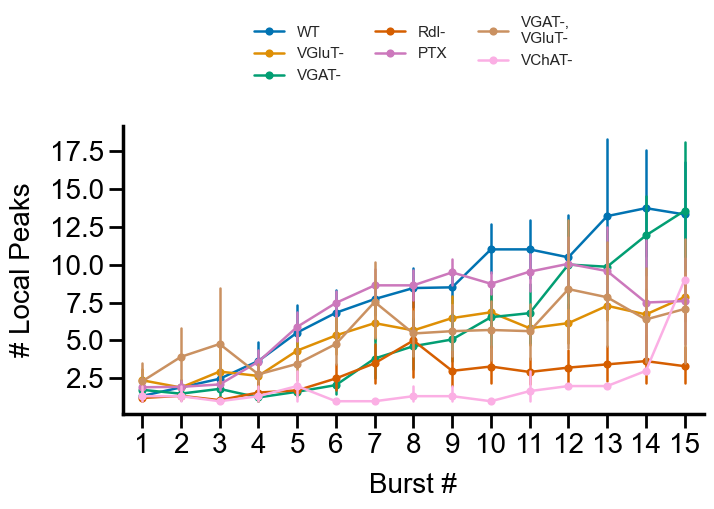

In [299]:
data = {"Group": [], "# Local Peaks": [], "Burst #": []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos.values():
            trace = emb.trace
            local_peaks = trace.compute_local_peaks(height=0.03, prominence=0.02)
            for i, lp in zip(range(15), local_peaks):
                data["# Local Peaks"].append(lp)
                data["Burst #"].append(i+1)
                data["Group"].append(group.name)

data = pd.DataFrame(data)

plot_pointplot(data, x="Burst #", y="# Local Peaks", category="Group", rc=episode_metrics_rc)

## Burst Rates, Grouped by Bins

/Users/alanaevora/Documents/Duke/code/pasna_analysis/notebooks/alanafunctions.py:402: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=dataframe, x=x, y=y, hue=category, linestyle=linestyle, ax=ax)


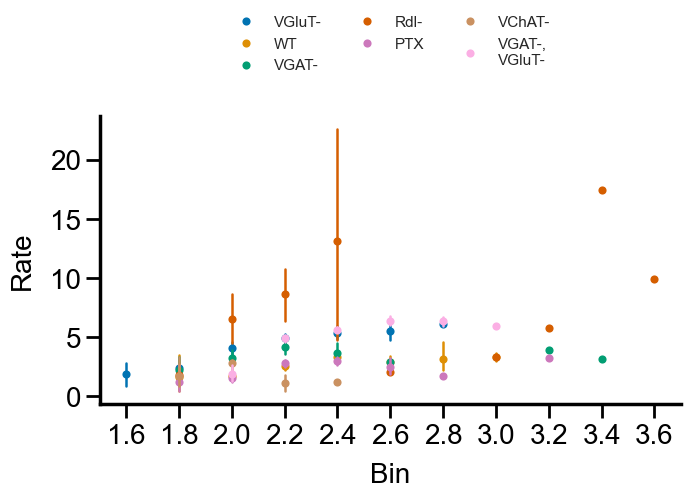

In [298]:
data = {"Group": [], "Rate": [], "Bin": []}

n_bins = 40
first_bin = 1
bin_width = 0.2
bins = np.arange(start=first_bin, stop=first_bin + n_bins * bin_width, step=bin_width)

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos.values():
            trace = emb.trace
            time_bins, idx_offset = emb.get_time_bins(bins)
            time_intervals = np.diff(time_bins) / 3600
            time_bin_idxs = utils.split_in_bins(trace.peak_times, time_bins) - 1
            freqs = Counter(time_bin_idxs)
            rates = {k + idx_offset: v / time_intervals[k] for k, v in freqs.items()}
            data["Group"].extend([str(group.name)] * len(rates))
            data["Rate"].extend(rates.values())
            data["Bin"].extend(rates.keys())

data = pd.DataFrame(data)

# make x labels
first_used_bin = data["Bin"].min()
last_used_bin = data["Bin"].max()
values_to_add = list(range(first_used_bin, last_used_bin))
missing_values = [val for val in values_to_add if val not in data["Bin"].values]
if missing_values:
    data = pd.concat([data, pd.DataFrame({"Bin": missing_values})])
x_labels = [
    round(bins[first_used_bin] + bin_width * i, 1)
    for i in range(last_used_bin - first_used_bin + 1)
]

plot_pointplot(data, x="Bin", y="Rate", category="Group", rc=episode_metrics_rc, xlabels=x_labels, lines=False)

## Burst Intervals, Grouped by Bins

/Users/alanaevora/Documents/Duke/code/pasna_analysis/notebooks/alanafunctions.py:402: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=dataframe, x=x, y=y, hue=category, linestyle=linestyle, ax=ax)


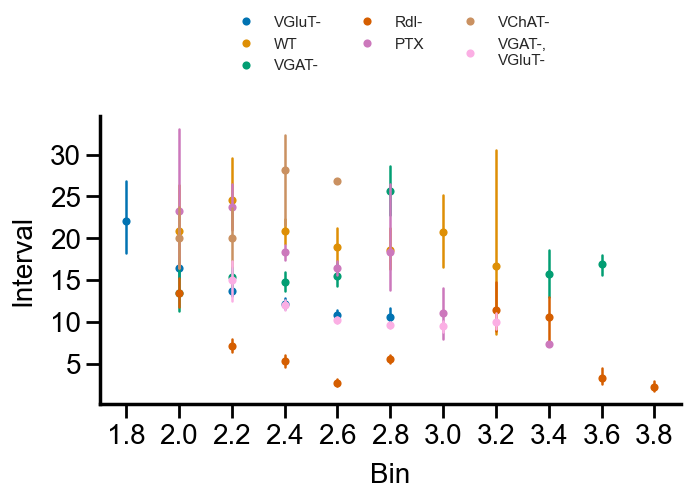

In [297]:
data = {"Group": [], "Interval": [], "Bin": []}

n_bins = 40
first_bin = 1
bin_width = 0.2
bins = [first_bin + j * bin_width for j in range(n_bins)]

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos.values():
            trace = emb.trace
            lin_dev_time = emb.lin_developmental_time()
            # skip the last peak because when we calculate peak intervals we loose a peak
            dev_time_at_peaks = lin_dev_time[trace.peak_idxes[:-1]]
            bin_idxs = utils.split_in_bins(dev_time_at_peaks, bins)
            data["Group"].extend([str(group.name)] * len(trace.peak_intervals))
            data["Interval"].extend(trace.peak_intervals / 60)
            data["Bin"].extend(bin_idxs)

data = pd.DataFrame(data)

# make x labels
first_used_bin = data["Bin"].min()
last_used_bin = data["Bin"].max()
values_to_add = list(range(first_used_bin, last_used_bin))
missing_values = [val for val in values_to_add if val not in data["Bin"].values]
if missing_values:
    data = pd.concat([data, pd.DataFrame({"Bin": missing_values})])
x_labels = [
    round(bins[first_used_bin] + bin_width * i, 1)
    for i in range(last_used_bin - first_used_bin + 1)
]

plot_pointplot(data, x="Bin", y="Interval", category="Group", rc=episode_metrics_rc, xlabels=x_labels, lines=False)